In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy
import matplotlib.pyplot as plt

from pathlib import Path
import os
import sys

import warnings
warnings.filterwarnings('ignore')

os.environ["CUDA_VISIBLE_DEVICES"] = "7"

import torch
from torch import nn
from torch import functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchsummary import summary
import safetensors

from transformers import WhisperTokenizer, WhisperFeatureExtractor
from transformers import GenerationConfig
from transformers import WhisperForConditionalGeneration
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

# import LORA modules
from peft import LoraConfig
from peft import LoraModel, AdaLoraModel, PeftModel, get_peft_model

from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, QuantileTransformer

from dataclasses import dataclass
from typing import Any, Dict, List, Union

import evaluate
metric = evaluate.load("wer")

from pathlib import Path
with open("../../default_paths.txt", 'r') as file:
    lines = file.readlines()
    data_path    = Path(lines[0].strip().split("=")[1])
    project_path = Path(lines[1].strip().split("=")[1])
    
utils_path = project_path / "utils"
train_path = data_path / "train"
test_path  = data_path / "test"
sys.path.insert(0, str(utils_path))

from data_utils_lesha import (process_all_files, 
process_string, 
save_sentences_to_txt,
load_sentences_from_txt,
RegularizeConfig,
ModelAdaptationConfig,
PreprocessConfig,
AugmentConfig,
configure_input_layers,
configure_learnable_layers,
WhisperAugmentDataset,
DataCollatorSpeechSeq2SeqWithPadding,
count_parameters, 
save_config, 
load_config)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
""" LOAD PRETRAINED MODEL COMPONENTS """

WHISPER_MODEL_NAME = "openai/whisper-large-v3"

regularize_config = RegularizeConfig()

# load feature/label processing engines|
feature_extractor = WhisperFeatureExtractor.from_pretrained(WHISPER_MODEL_NAME)
tokenizer = WhisperTokenizer.from_pretrained(WHISPER_MODEL_NAME, task="transcribe")
model = WhisperForConditionalGeneration.from_pretrained(WHISPER_MODEL_NAME, **regularize_config.to_dict())

if ".en" not in WHISPER_MODEL_NAME:
    model.generation_config.language = "english"
    model.generation_config.task = "transcribe"
    model.generation_config.forced_decoder_ids = None

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Adapt model

In [3]:
lora_config = LoraConfig(r=8, 
                         task_type="SEQ_2_SEQ_LM", 
                         use_rslora=True, 
                         use_dora=True)

adaptation_config = ModelAdaptationConfig(fs_whisper=50, 
                                          inputs_stack="concat",
                                          conv1_time_kernel_size=9, 
                                          conv2_time_kernel_size=5,
                                          conv1_out_channels=1280, 
                                          conv_layer_idx_stride_2=2,
                                          adapt_model="full",  # full, freeze, lora
                                          freeze_modules=("encoder", "adapter", "decoder", "sanyafreeze"), # conv, encoder, adapter, decoder, sanyafreeze
                                          low_rank_adaptation_modules=("decoder"), # encoder, decoder or full
                                          low_rank_adaptation_targets=("q_proj", "k_proj", "v_proj", "out_proj", "fc1", "fc2"), 
                                          lora_config=lora_config,
                                          n_electrodes=256, n_features=2, max_duration=30)

In [4]:
model = configure_input_layers(model, adaptation_config)

Input size:  torch.Size([10, 512, 1500])
Conv1 output size:  torch.Size([10, 1280, 1500])
Conv2 output size:  torch.Size([10, 1280, 1500])

 Number of parameters conv1:
Conv1d(512, 1280, kernel_size=(9,), stride=(1,), padding=(4,))
Total: 5.90M, Trainable: 5.90M

Number of parameters conv2: 
Conv1d(1280, 1280, kernel_size=(5,), stride=(1,), padding=(2,))
Total: 8.19M, Trainable: 8.19M


In [5]:
model = configure_learnable_layers(model, adaptation_config)
model

Full model parameters: 
Total: 1552.17M, Trainable: 1550.25M

Returning full model...


WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(512, 1280, kernel_size=(9,), stride=(1,), padding=(4,))
      (conv2): Conv1d(1280, 1280, kernel_size=(5,), stride=(1,), padding=(2,))
      (embed_positions): Embedding(1500, 1280)
      (layers): ModuleList(
        (0-31): 32 x WhisperEncoderLayer(
          (self_attn): WhisperSdpaAttention(
            (k_proj): Linear(in_features=1280, out_features=1280, bias=False)
            (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1280, out_features=5120, bias=True)
          (fc2): Linear(in_features=5120, out_features=1280, bia

## Load previous checkpoint

In [6]:
prev_experiment_path = data_path / "experiments" / WHISPER_MODEL_NAME / "GRADUAL_STEP1_conv"
checkpoint_path = prev_experiment_path / "checkpoint-1100"

weights1 = safetensors.torch.load_file(checkpoint_path / "model-00001-of-00002.safetensors")
weights2 = safetensors.torch.load_file(checkpoint_path / "model-00002-of-00002.safetensors")
weights = {**weights1, **weights2}

model.load_state_dict(weights, strict=False)
count_parameters(model)

Total: 1552.17M, Trainable: 1550.25M


(1552174080, 1550254080)

## Unfreeze next module

In [7]:
# unfreeze encoder (next adapter)
for p_name, p in model.model.encoder.named_parameters():
    p.requires_grad = True


# freeze decoder and adapter
for p_name, p in model.model.decoder.named_parameters():
    p.requires_grad = False

count_parameters(model)

Total: 1552.17M, Trainable: 645.65M


(1552174080, 645652480)

## Load data and scale dataset

In [8]:
%%time
data_train = process_all_files(train_path)
data_test = process_all_files(test_path)

print(data_train.keys())

XV = np.concatenate(data_train['voltage_list'], axis=0)
# scalerV = RobustScaler(quantile_range=(0.01, 0.99), unit_variance=True).fit(XV)
#scalerV = QuantileTransformer(n_quantiles=3000, output_distribution='uniform', subsample=30000).fit(XV)
scalerV = StandardScaler().fit(XV)

XS = np.concatenate(data_train['spike_list'], axis=0)
scalerS = MinMaxScaler(feature_range=(-1, 1)).fit(XS)

XV, XS = None, None

dict_keys(['voltage_list', 'spike_list', 'sentence_list', 'date_list'])
CPU times: user 14.8 s, sys: 8.84 s, total: 23.7 s
Wall time: 26.1 s


## Define train and eval datasets with augmentations

In [10]:
check_augments = False
n_train = 100 if check_augments else len(data_train['voltage_list'])

preprocess_config = PreprocessConfig(inputs_stack=adaptation_config.inputs_stack,
                                     voltage_scaler=scalerV, 
                                     spike_scaler=scalerS, 
                                     sentence_tokenizer=tokenizer,
                                     eval_filter_freq=15,
                                     filter_voltage=True,
                                     filter_spikes=False,
                                     fs_orig=50,  
                                     fs_whisper=adaptation_config.fs_whisper,
                                     max_duration=30.0,
                                     resample_type='interpolate')

augment_config = AugmentConfig(total_augment_probability=0.25, 
                               channel_mask_probability=0.1,
                               channel_mask_fraction_limits=(0.01, 0.02),
                               time_mask_probability=0.1,
                               time_mask_fraction_limits=(0.01, 0.02),
                               time_stretch_probability=0, 
                               time_stretch_limits=(0.95, 1.05),
                               voltage_noise_probability=0.3,
                               voltage_noise_snr_limits=(8, 20),
                               voltage_drift_limits=(-0.1, 0.1),
                               spike_noise_probability=0.1,
                               spike_noise_per_bin_probability=0.005,
                               no_filter_probability=0.5,
                               filter_cutoff_freq_limits=(preprocess_config.eval_filter_freq, 25),
                               random_signal_shift_probability=0.7)


train_dataset = WhisperAugmentDataset(data_train['voltage_list'][:n_train], 
                                           data_train['spike_list'][:n_train], 
                                           data_train['sentence_list'][:n_train],
                                           preprocess_config, 
                                           augment_config, 
                                           is_eval=False)


eval_dataset = WhisperAugmentDataset(data_test['voltage_list'], 
                                           data_test['spike_list'], 
                                           data_test['sentence_list'],
                                           preprocess_config, 
                                           augment_config, 
                                           is_eval=True)

Processing dataset...: 100%|██████████| 8800/8800 [00:07<00:00, 1123.60it/s]


Input processing time ~ 4.9 ms


Processing dataset...: 100%|██████████| 880/880 [00:03<00:00, 284.31it/s]

Input processing time ~ 1.8 ms


Original shape (256, 591)
0
the eastern coast is a place for pure pleasure and excitement


torch.Size([512, 1500])

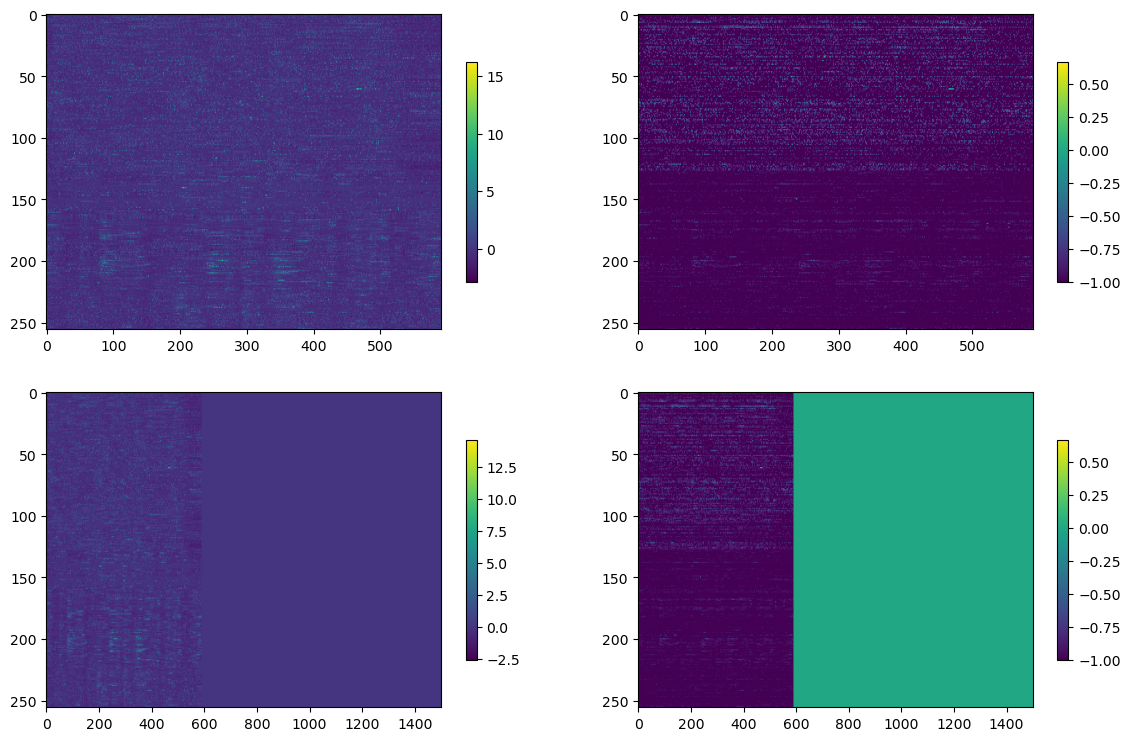

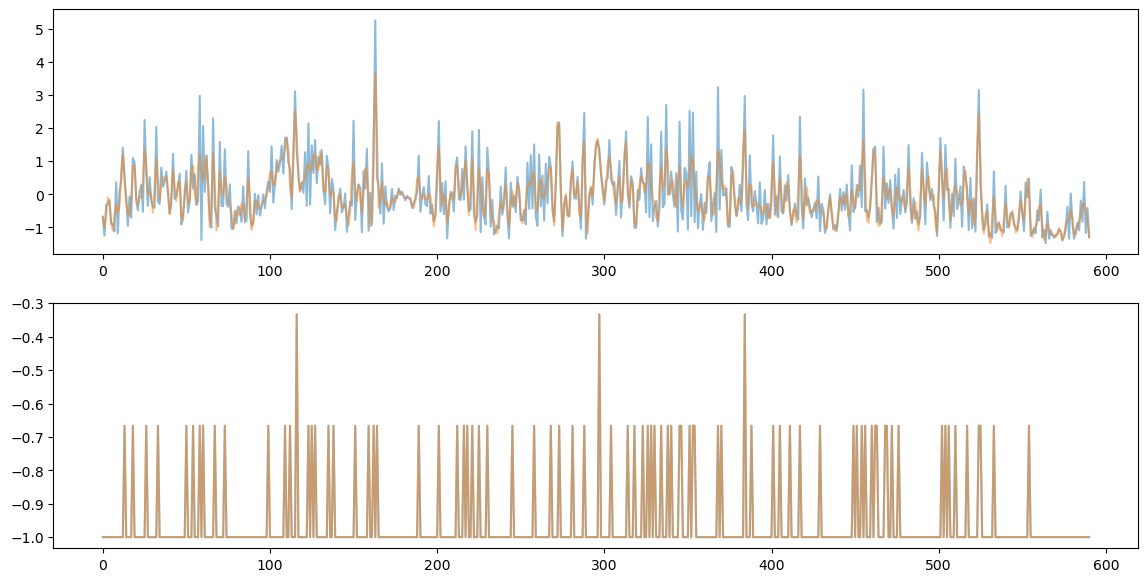

In [11]:
idx = 10
chan = 3

step = 1 if adaptation_config.fs_whisper == 50 else 2

dataset = train_dataset
data = data_train

voltage = scalerV.transform(data['voltage_list'][idx]).T
spikes = scalerS.transform(data['spike_list'][idx]).T

print("Original shape", voltage.shape)

plt.figure(figsize=(14, 9))

# with scaling
plt.subplot(221)
plt.imshow(voltage, aspect='auto')
plt.colorbar(shrink=0.7)

plt.subplot(222)
plt.imshow(spikes, aspect='auto')
plt.colorbar(shrink=0.7)

# Augmentations etc.
input_features = dataset[idx]['input_features'].numpy()
if adaptation_config.inputs_stack == "concat":
    cfg = adaptation_config
    new_input_features = np.empty((cfg.n_electrodes, cfg.n_features, (cfg.max_duration * cfg.fs_whisper)))
    new_input_features[:, 0, :] = input_features[:cfg.n_electrodes, :]
    new_input_features[:, 1, :] = input_features[cfg.n_electrodes:, :]
    input_features = new_input_features

start_idx = np.arange(input_features.shape[-1] - 1)[(np.diff(np.sum(np.abs(input_features[:, 0, :]), axis=0)) > 0)][0]
start_idx = 0 if start_idx == 2 else start_idx
print(start_idx)
    
plt.subplot(223)
plt.imshow(input_features[:, 0], aspect='auto')
plt.colorbar(shrink=0.7)

plt.subplot(224)
plt.imshow(input_features[:, 1], aspect='auto')
plt.colorbar(shrink=0.7)


plt.figure(figsize=(14, 7))

plt.subplot(211)
plt.plot(voltage[chan], alpha=0.5)
plt.plot(input_features[chan, 0, start_idx:start_idx+voltage.shape[1]:step], alpha=0.5)


plt.subplot(212)
plt.plot(spikes[chan], alpha=0.5)
plt.plot(input_features[chan, 1, start_idx:start_idx+voltage.shape[1]:step], alpha=0.5)
print(data_train['sentence_list'][idx])
dataset[0]['input_features'].shape

## Training setup

### Setup wandb and hugging face login

## Set training parameters

In [14]:
# import wandb
# wandb.login(key="84800673dd80a5eac8bb77b02728e733f806fd10")

experiment_path = data_path / "experiments" / WHISPER_MODEL_NAME / "GRADUAL_STEP2_encoder"
experiment_path.mkdir(parents=True, exist_ok=True)

config_names = ["augment_config.json", "preprocess_config.json", "adaptation_config.json", "regularize_config.json"]
configs = [augment_config, preprocess_config, adaptation_config, regularize_config]

for i in range(len(config_names)):
    configs[i].to_json_file(experiment_path / config_names[i])

batch_size = 16
epoch_length = int(len(train_dataset) / batch_size)

training_args = Seq2SeqTrainingArguments(
    output_dir=experiment_path,  # change to a repo name of your choice
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=int(16 / batch_size),  # increase by 2x for every 2x decrease in batch size
    learning_rate=2.5e-5,
    num_train_epochs=8,
    warmup_steps=1 * epoch_length,
    gradient_checkpointing=True,
    fp16=False,
    evaluation_strategy="steps",
    per_device_eval_batch_size=batch_size,
    predict_with_generate=True,
    generation_max_length=32,
    save_steps=int(epoch_length / 2),
    eval_steps=int(epoch_length / 2),
    logging_steps=int(epoch_length / 16),
    report_to=["wandb"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=False,
)

# initialize data collator
data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    tokenizer=tokenizer,
    feature_extractor=feature_extractor,
    decoder_start_token_id=model.config.decoder_start_token_id,
)

# defining here because using a concerete tokenizer instance! 
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

# initialize trainer
trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
)

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


## Train

In [20]:
trainer.train()

`use_cache = True` is incompatible with gradient checkpointing. Setting `use_cache = False`...


Step,Training Loss,Validation Loss,Wer
275,3.123900,2.989141,128.210258
550,3.133200,2.990524,107.493634
825,3.005900,2.943290,118.497636
1100,2.985400,2.912844,115.478356
1375,2.949100,2.917611,105.001819
1650,2.936700,2.826661,113.986904
1925,2.627000,2.128102,94.125136
2200,1.263100,1.186317,56.165879
2475,0.970400,0.974171,46.926155
2750,0.832100,0.861262,41.233176


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'begin_suppress_tokens': [220, 50257]}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'begin_suppress_tokens': [220, 50257]}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead.

TrainOutput(global_step=4400, training_loss=1.6737130721590736, metrics={'train_runtime': 62289.4546, 'train_samples_per_second': 1.13, 'train_steps_per_second': 0.071, 'total_flos': 4.81184723238912e+20, 'train_loss': 1.6737130721590736, 'epoch': 8.0})

### Evaluate from checkpoint

In [32]:
experiment_path

PosixPath('/mnt/beegfs/home/atimcenko/at_code/brain2text/data/experiments/openai/whisper-large-v3/experiment-6_features-512_interleave_augment-eval_model-max')

In [31]:
prev_experiment_path = data_path / "experiments" / WHISPER_MODEL_NAME / "GRADUAL_STEP2_encoder"
checkpoint_path = prev_experiment_path / "checkpoint-2750"

weights1 = safetensors.torch.load_file(checkpoint_path / "model-00001-of-00002.safetensors")
weights2 = safetensors.torch.load_file(checkpoint_path / "model-00002-of-00002.safetensors")
weights = {**weights1, **weights2}

model.load_state_dict(weights, strict=False)

_IncompatibleKeys(missing_keys=['proj_out.weight'], unexpected_keys=[])

In [32]:
for idx in range(0, 10):
    true_text = data_test['sentence_list'][idx]
    print(f"True: {true_text}")
    input_tensor = eval_dataset[idx]['input_features'].to('cuda').type(torch.float).reshape((1, 512, 1500))
    ids = model.generate(input_tensor).cpu()
    pred_text = tokenizer.decode(ids[0], skip_special_tokens=True)
    print(f"Pred: {pred_text}\n")

True: theocracy reconsidered
Pred: i actually did get it

True: rich purchased several signed lithographs
Pred: jake purchased several heavy destroyers

True: so rules we made in unabashed collusion
Pred: we all try much to minimize pollution

True: lori's costume needed black gloves to be completely elegant
Pred: joyous extreme feeling makes love to me the mental illusion

True: the tooth fairy forgot to come when roger's tooth fell out
Pred: the early birdie was like a ham fan watching tooth decayed

True: that stinging vapor was caused by chloride vaporization
Pred: that same anniversary was called the third financial year

True: before thursday's exam review every formula
Pred: my daughter still likes to eat my own real cheap vegetables

True: wildfire near sunshine forces park closures
Pred: not only do they seem to be both generous

True: the word means it won't boil away easily nothing else
Pred: the young man at work was never usually ready to dance

True: would a blue feather 

**Change num_beans**

In [33]:
for idx in range(0, 10):
    true_text = data_test['sentence_list'][idx]
    print(f"True: {true_text}")
    input_tensor = eval_dataset[idx]['input_features'].to('cuda').type(torch.float).reshape((1, 512, 1500))
    ids = model.generate(input_tensor, num_beams=10, num_beam_groups=5, diversity_penalty=0.1).cpu()
    pred_text = tokenizer.decode(ids[0], skip_special_tokens=True)
    print(f"Pred: {pred_text}\n")

True: theocracy reconsidered
Pred: i actually did get it

True: rich purchased several signed lithographs
Pred: try brushing them cleanly through your eyes

True: so rules we made in unabashed collusion
Pred: he will be moved in enterprise solutions

True: lori's costume needed black gloves to be completely elegant
Pred: joyous cash from men makes lives so much easier

True: the tooth fairy forgot to come when roger's tooth fell out
Pred: the olive tree brought up the time when vultures soothed their head

True: that stinging vapor was caused by chloride vaporization
Pred: that same employee was charged with a third sexual misdemeanor

True: before thursday's exam review every formula
Pred: buy three three-thousand-thousand-thousand-thousand-thousand-thousand-thousand-thousand-thousand-thousand-thousand-thousand-thousand-thousand-thousand-thousand-thousand-thousand-thousand-thousand-thousand-thousand-thousand-thousand-thousand-thousand-thousand-thousand-thousand-thousand-thousand-thous

In [39]:
model

WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(80, 768, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(768, 768, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 768)
      (layers): ModuleList(
        (0-11): 12 x WhisperEncoderLayer(
          (self_attn): WhisperSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
        

In [8]:
model.encoder

NameError: name 'model' is not defined